# read xlss / determine target and features/ do PCA

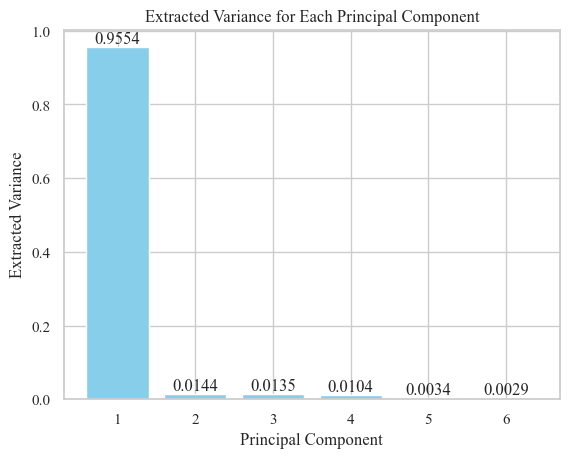

In [79]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Replace with the actual file path
file_path = 'C:\\Users\\HP\\Desktop\\Zayande rood.xlsx'

# Specify the sheet name
sheet_name = 'P'

# Read the Excel file into a pandas DataFrame for the specified sheet
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract the features (2nd to 7th columns)
features = df.iloc[:, 1:7].values  # Columns 2 to 7 (0-indexed)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Create a DataFrame for the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
df_explained_variance = pd.DataFrame(data=explained_variance_ratio, columns=['Explained Variance'])

# Plot the explained variance for each principal component as a bar chart
fig, ax = plt.subplots()
bars = ax.bar(range(1, len(df_explained_variance) + 1), df_explained_variance['Explained Variance'], color='skyblue')

# Add labels and title
ax.set_xlabel('Principal Component')
ax.set_ylabel('Extracted Variance')
ax.set_title('Extracted Variance for Each Principal Component')

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()
#In summary, the code helps you visualize how much variance in the data is captured by each principal component, which can be useful for dimensionality reduction and understanding the importance of each feature in the dataset.








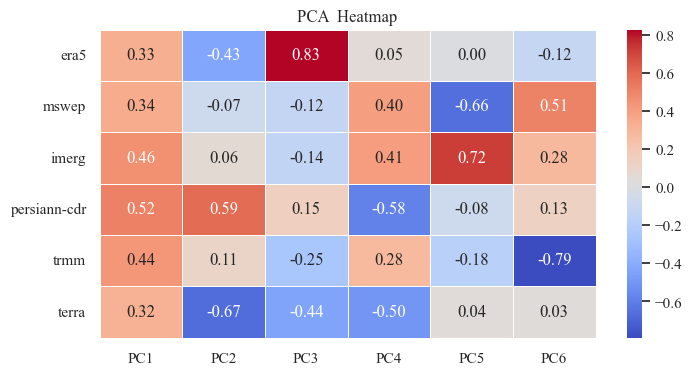

In [73]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with the actual file path
file_path = 'C:\\Users\\HP\\Desktop\\Zayande rood.xlsx'

# Specify the sheet name
sheet_name = 'P'

# Read the Excel file into a pandas DataFrame for the specified sheet
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract the features (2nd to 7th columns)
features = df.iloc[:, 1:7].values  # Columns 2 to 7 (0-indexed)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Create a DataFrame for the principal components
columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
df_pca = pd.DataFrame(data=principal_components, columns=columns)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(pca.components_.T, columns=columns, index=df.columns[1:7])

# Plot heatmap for loadings
plt.figure(figsize=(8, 4))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)
plt.title('PCA  Heatmap')
plt.show()


# create model / train test validate split / Evaluations ( (Validation Set)

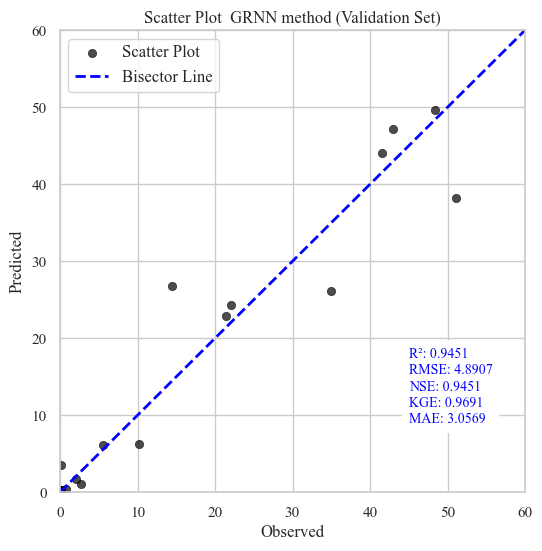

Test Set Performance:
R²: 0.9317
RMSE: 4.8164
NSE: 0.9317
KGE: 0.9091
MAE: 2.9567


In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# Replace with the actual file path
file_path = 'C:\\Users\\HP\\Desktop\\Zayande rood.xlsx'

# Specify the sheet name
sheet_name = 'P'

# Read the Excel file into a pandas DataFrame for the specified sheet
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract the features (2nd to 7th columns) and the target variable (12th column)
X_original = df.iloc[:, 1:7].values  # Original features
y = df.iloc[:, 11].values   # Target variable

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_original, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features (important for GRNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

class CustomGRNN:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        dists = cdist(X_test, self.X_train)
        weights = np.exp(-dists ** 2 / (2 * self.sigma ** 2))
        weights /= np.sum(weights, axis=1, keepdims=True)
        y_pred = np.dot(weights, self.y_train)
        return y_pred.flatten()

    def tune_sigma(self, X_val, y_val, sigma_candidates):
        best_sigma = None
        best_r2 = -float('inf')

        for sigma in sigma_candidates:
            self.sigma = sigma
            y_val_pred = self.predict(X_val)
            r2 = r2_score(y_val, y_val_pred)

            if r2 > best_r2:
                best_r2 = r2
                best_sigma = sigma

        self.sigma = best_sigma
        return best_sigma

    def normalize_target(self, y):
        return (y - np.min(y)) / (np.max(y) - np.min(y))

    def sensitivity_analysis(self, X_test, feature_index):
        base_predictions = self.predict(X_test)

        perturbed_X_test = X_test.copy()
        perturbed_X_test[:, feature_index] += 0.1 * np.std(X_test[:, feature_index])

        perturbed_predictions = self.predict(perturbed_X_test)

        sensitivity = 100 * np.mean((perturbed_predictions - base_predictions) / base_predictions)

        return sensitivity

# Create a GRNN model
grnn = CustomGRNN()

# Train the model on the training set
grnn.fit(X_train_pca, y_train)

# Make predictions on the validation set
y_val_pred = grnn.predict(X_val_pca)

# Scatter plot of actual vs. predicted values on the validation set
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred, alpha=0.7, edgecolors='black', linewidth=0.5, label='Scatter Plot', color='black')
plt.plot([0, 60], [0, 60], color='blue', linestyle='--', linewidth=2, label='Bisector Line')

# Define KGE function
def calculate_kge(observed, simulated):
    obs_mean, sim_mean = np.mean(observed), np.mean(simulated)
    obs_std, sim_std = np.std(observed), np.std(simulated)
    obs_corr = np.corrcoef(observed, simulated)[0, 1]

    kge_val = 1 - np.sqrt((obs_corr - 1) ** 2 + (obs_std / sim_std - 1) ** 2 + (obs_mean / sim_mean - 1) ** 2)
    return kge_val

# Display mean bias assessment metrics for the validation set
text_message = f'R²: {r2_score(y_val, y_val_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}\nNSE: {1 - (mean_squared_error(y_val, y_val_pred) / np.var(y_val)):.4f}\nKGE: {calculate_kge(y_val, y_val_pred):.4f}\nMAE: {mean_absolute_error(y_val, y_val_pred):.4f}'
plt.text(0.75, 0.15, text_message, transform=plt.gca().transAxes, fontsize=10, color='blue', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

plt.title('Scatter Plot  GRNN method (Validation Set)', fontsize=12)
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.xlim([0, 60])  # Set x-axis range
plt.ylim([0, 60])  # Set y-axis range
plt.show()

# Evaluate performance on the test set
y_test_pred = grnn.predict(X_test_pca)

# Display mean bias assessment metrics for the test set
test_text_message = f'R²: {r2_score(y_test, y_test_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}\nNSE: {1 - (mean_squared_error(y_test, y_test_pred) / np.var(y_test)):.4f}\nKGE: {calculate_kge(y_test, y_test_pred):.4f}\nMAE: {mean_absolute_error(y_test, y_test_pred):.4f}'
print("Test Set Performance:")
print(test_text_message)


# entire set

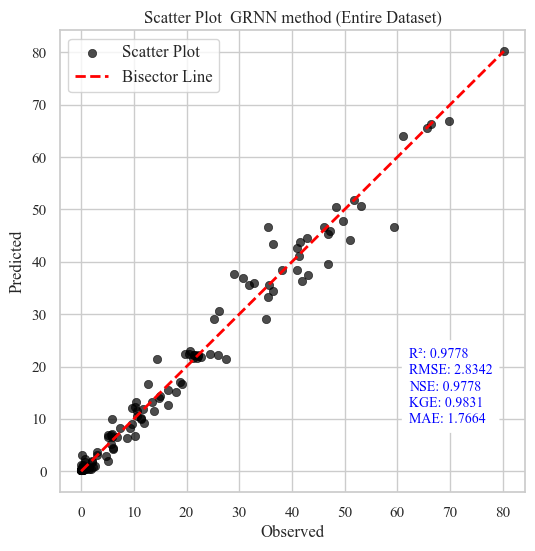

In [100]:
# Scatter plot of actual vs. predicted values for the entire dataset
plt.figure(figsize=(6, 6))
plt.scatter(y_all, y_all_pred, alpha=0.7, edgecolors='black', linewidth=0.5, label='Scatter Plot', color='black')
plt.plot([min(y_all), max(y_all)], [min(y_all), max(y_all)], color='red', linestyle='--', linewidth=2, label='Bisector Line')

# Display mean bias assessment metrics for the entire dataset
text_message = f'R²: {r2_score(y_all, y_all_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y_all, y_all_pred)):.4f}\nNSE: {1 - (mean_squared_error(y_all, y_all_pred) / np.var(y_all)):.4f}\nKGE: {calculate_kge(y_all, y_all_pred):.4f}\nMAE: {mean_absolute_error(y_all, y_all_pred):.4f}'
plt.text(0.75, 0.15, text_message, transform=plt.gca().transAxes, fontsize=10, color='blue', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

plt.title('Scatter Plot  GRNN method (Entire Dataset)', fontsize=12)
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.show()


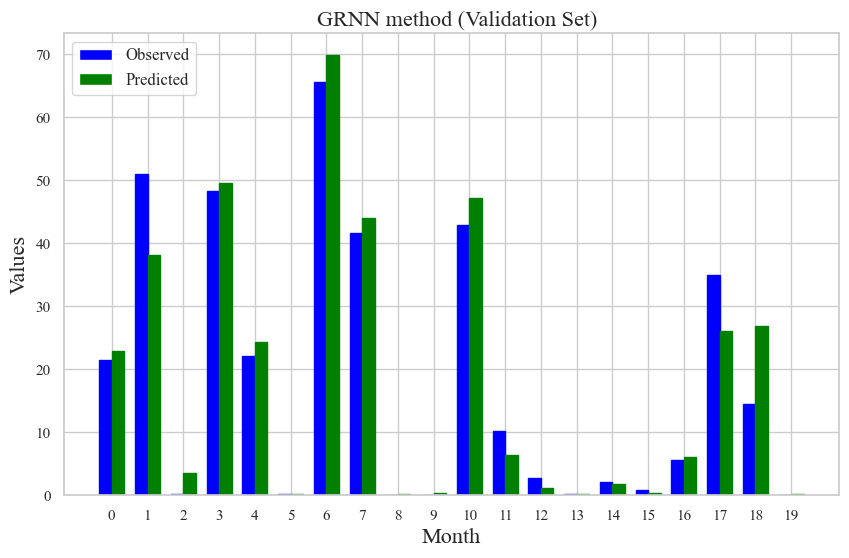

R²: 0.9317
RMSE: 4.8164
NSE: 0.9317
KGE: 0.9091
MAE: 2.9567


In [102]:
# Bar plot of actual vs. predicted values on the validation set
width = 0.35
ind = np.arange(len(y_val))
plt.figure(figsize=(10, 6))
bars1 = plt.bar(ind, y_val, width, label='Observed', color='blue')
bars2 = plt.bar(ind + width, y_val_pred, width, label='Predicted', color='green')

# Display mean bias assessment metrics for the validation set
#text_message = f'R²: {r2_score(y_val, y_val_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}\nNSE: {1 - (mean_squared_error(y_val, y_val_pred) / np.var(y_val)):.4f}'
#plt.text(0.75, 0.15, text_message, transform=plt.gca().transAxes, fontsize=14, color='blue', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

plt.title('  GRNN method (Validation Set)', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(loc='upper left', fontsize='large')

# Move the legend to the upper left
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize='medium')

# Remove the bisector line
for bar in bars1:
    bar.set_edgecolor('blue')

for bar in bars2:
    bar.set_edgecolor('green')

plt.xticks(ind + width / 2, ind)
plt.grid(True)
plt.show()

# Evaluate performance on the test set
y_test_pred = grnn.predict(X_test_pca)

# Display mean bias assessment metrics for the test set
#test_text_message = f'R²: {r2_score(y_test, y_test_pred):.4f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}\nNSE: {1 - (mean_squared_error(y_test, y_test_pred) / np.var(y_test)):.4f}'
#print("Test Set Performance:")
print(test_text_message)


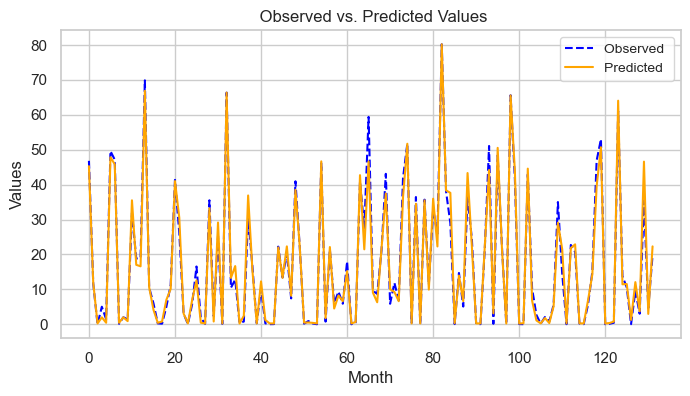

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style (optional, but can enhance the appearance)
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.lineplot(data=y_all, label='Observed ', linestyle='--', color='blue')  # Use dash line for actual values with blue color
sns.lineplot(data=y_all_pred, label='Predicted ', color='orange')  # Use solid line for predicted values with orange color
plt.title(' Observed vs. Predicted Values', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend(loc='upper right', fontsize='small')
plt.show()


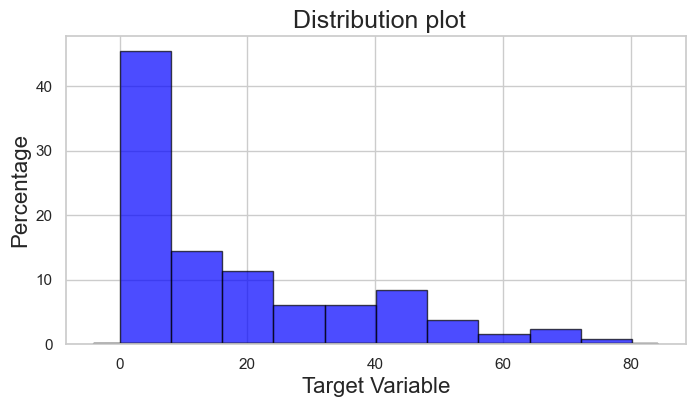

In [32]:
from scipy.stats import norm

# ... (existing code)

# Plot histogram with normal distribution curve
plt.figure(figsize=(8, 4))

# Calculate the percentage of values in each bin
weights = np.ones_like(y) / len(y)

plt.hist(y, bins=10, weights=weights * 100, color='blue', edgecolor='black', alpha=0.7)

# Fit a normal distribution to the data
mu, std = norm.fit(y)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title(' Distribution plot', fontsize=18)
plt.xlabel('Target Variable', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.grid(True)

plt.show()
